In [1]:
import os
import cv2 as cv
from glob import glob

categories = ['yes', 'nobody']
raw_dir = {'train': './raw/train', 'val': './raw/val'}
output_dir = './images'
extensions = ('*.jpg', '*.png')
img_size = 299  # match Xception input size


def resize(image):
    h, w, c = image.shape
    cropped = image
    if h < w:
        diff = (w - h) // 2
        cropped = image[:, diff: (diff + h), :]
    elif h > w:
        diff = (h - w) // 2
        cropped = image[diff: (diff + w), :, :]

    h, w, c = cropped.shape
    if h > img_size:    # shrink
        return cv.resize(cropped, (img_size, img_size), interpolation=cv.INTER_AREA)
    elif h < img_size:  # enlarge
        return cv.resize(cropped, (img_size, img_size), interpolation=cv.INTER_CUBIC)
    else:
        return cropped


if not os.path.exists(output_dir):
    os.mkdir(output_dir)

for dataset, path in raw_dir.items():
    output_set_dir = os.path.join(output_dir, dataset)
    if not os.path.exists(output_set_dir):
        os.mkdir(output_set_dir)

    for cat in categories:
        output_cat_dir = os.path.join(output_set_dir, cat)
        if not os.path.exists(output_cat_dir):
            os.mkdir(output_cat_dir)

        input_dir = os.path.join(path, cat)
        filenames = list()
        for ext in extensions:
            filenames.extend(glob(os.path.join(input_dir, ext)))

        for i, file in enumerate(filenames):
            print('processing:', file)
            img = cv.imread(file)
            resized = resize(img)
            img_name = str(i) + '.png'
            filepath = os.path.join(output_cat_dir, img_name)
            cv.imwrite(filepath, resized)



processing: ./raw/train\yes\0.jpg
processing: ./raw/train\yes\10.jpg
processing: ./raw/train\yes\11.jpg
processing: ./raw/train\yes\12.jpg
processing: ./raw/train\yes\13.jpg
processing: ./raw/train\yes\14.jpg
processing: ./raw/train\yes\15.jpg
processing: ./raw/train\yes\16.jpg
processing: ./raw/train\yes\18.jpg
processing: ./raw/train\yes\19.jpg
processing: ./raw/train\yes\2.jpg
processing: ./raw/train\yes\20.jpg
processing: ./raw/train\yes\21.jpg
processing: ./raw/train\yes\22.jpg
processing: ./raw/train\yes\23.jpg
processing: ./raw/train\yes\24.jpg
processing: ./raw/train\yes\25.jpg
processing: ./raw/train\yes\26.jpg
processing: ./raw/train\yes\27.jpg
processing: ./raw/train\yes\28.jpg
processing: ./raw/train\yes\29.jpg
processing: ./raw/train\yes\3.jpg
processing: ./raw/train\yes\30.jpg
processing: ./raw/train\yes\31.jpg
processing: ./raw/train\yes\32.jpg
processing: ./raw/train\yes\33.jpg
processing: ./raw/train\yes\34.jpg
processing: ./raw/train\yes\35.jpg
processing: ./raw/train

In [2]:
import os
from glob import glob
import cv2 as cv
import numpy as np

categories = ['yes', 'nobody']
data_dir = {'train': './images/train', 'val': './images/val'}


def load_data():
    """80 images per class in training set, 10 images per class in validation set"""

    x_train = list()
    x_val = list()
    y_train = list()
    y_val = list()

    for dataset, path in data_dir.items():
        for i, cat in enumerate(categories):
            cur_dir = os.path.join(path, cat)
            filenames = glob(os.path.join(cur_dir, '*.png'))
            for file in filenames:
                img = cv.imread(file)
                if dataset == 'train':
                    x_train.append(img)
                    y_train.append(i)
                else:
                    x_val.append(img)
                    y_val.append(i)

    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    x_val = np.asarray(x_val)
    y_val = np.asarray(y_val)

    return (x_train, y_train), (x_val, y_val)


# save the dataset
room_dataset = load_data()
np.save('data/iot_dataset.npy', room_dataset)


In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import Xception
import numpy as np

# load data
(x_train, y_train), (x_val, y_val) = np.load('data/iot_dataset.npy')

# normalize data
channel_mean = np.mean(x_train, axis=(0, 1, 2))
channel_std = np.std(x_train, axis=(0, 1, 2))

# mean, std calculated here are also used in predicting test images: predict.py
# channel_mean = np.array([110.73151039, 122.90935242, 136.82249855])
# channel_std = np.array([69.39734207, 67.48444001, 66.66808662])

x_train = x_train.astype('float32')
x_val = x_val.astype('float32')

for i in range(3):
    x_train[:, :, :, i] = (x_train[:, :, :, i] - channel_mean[i]) / channel_std[i]
    x_val[:, :, :, i] = (x_val[:, :, :, i] - channel_mean[i]) / channel_std[i]

# define data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

augmented_data = x_train.copy()
train_labels = y_train.copy()

# flow in advance, get augmented training data and corresponding labels
for i in range(19):
    for img, label in datagen.flow(x_train, y_train,batch_size=100):
        print(i)
        augmented_data = np.vstack((augmented_data, img))
        print(augmented_data.shape)
        train_labels = np.hstack((train_labels, label))
        print(train_labels.shape)
        break

# pre-trained model to extract features
base_model = Xception(include_top=False, weights='imagenet', pooling='avg')
train_features = base_model.predict(augmented_data,batch_size=20)
np.savetxt('data/train_features.csv', train_features, fmt='%.5f', delimiter=',')
np.savetxt('data/train_labels.csv', train_labels, fmt='%1d', delimiter=',')

# save validation features and label
val_features = base_model.predict(x_val)
np.savetxt('data/val_features.csv', val_features, fmt='%.5f', delimiter=',')
np.savetxt('data/val_labels.csv', y_val, fmt='%1d', delimiter=',')


E:\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


0
(260, 299, 299, 3)
(260,)
1
(360, 299, 299, 3)
(360,)
2
(460, 299, 299, 3)
(460,)
3
(560, 299, 299, 3)
(560,)
4
(660, 299, 299, 3)
(660,)
5
(760, 299, 299, 3)
(760,)
6
(860, 299, 299, 3)
(860,)
7
(960, 299, 299, 3)
(960,)
8
(1060, 299, 299, 3)
(1060,)
9
(1160, 299, 299, 3)
(1160,)
10
(1260, 299, 299, 3)
(1260,)
11
(1360, 299, 299, 3)
(1360,)
12
(1460, 299, 299, 3)
(1460,)
13
(1560, 299, 299, 3)
(1560,)
14
(1660, 299, 299, 3)
(1660,)
15
(1760, 299, 299, 3)
(1760,)
16
(1860, 299, 299, 3)
(1860,)
17
(1960, 299, 299, 3)
(1960,)
18
(2060, 299, 299, 3)
(2060,)


In [4]:
from keras import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import time


epochs = 10
batch_size = 16
iterations = 200     # 192 * 20 / 32
weight_decay = 0.01

# load feature vectors and labels
x_train = np.genfromtxt('data/train_features.csv', dtype=np.float32, delimiter=',')
x_val = np.genfromtxt('data/val_features.csv', dtype=np.float32, delimiter=',')
y_train = np.genfromtxt('data/train_labels.csv', dtype=np.uint8)
y_val = np.genfromtxt('data/val_labels.csv', dtype=np.uint8)

# custom head: one hidden layer.
model = Sequential([
    Dense(10, activation='sigmoid', kernel_regularizer=regularizers.l2(weight_decay)),
    Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(weight_decay))
])

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# set up callback
cur_time = str(int(time.time()))
cbks = [
    TensorBoard(log_dir='./log/room_' + cur_time),
    ModelCheckpoint('./ckpt/' + cur_time + '_{epoch:02d}-{val_loss:.2f}.hdf5', save_best_only=True)
]

# training
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=False,      # already shuffled during augmentation
    validation_data=(x_val, y_val),
    callbacks=cbks,
    verbose=1
)

# save and plot result
model.save('./model/iot_model_{}.h5'.format(cur_time))

train_error = [(1-acc)*100 for acc in history.history['acc']]
val_error = [(1-acc)*100 for acc in history.history['val_acc']]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
plt.tight_layout(pad=3, w_pad=2)
fig.suptitle('Messy Room Classifier', fontsize=16, fontweight='bold')
ax1.set_xlabel('Epochs', fontsize=14)
ax1.set_ylabel('Error(%)', fontsize=14)
ax1.plot(train_error, label='Training Error')
ax1.plot(val_error, label='Validation Error')
ax1.legend()

ax2.set_xlabel('Epochs', fontsize=14)
ax2.set_ylabel('Loss', fontsize=14)
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.legend()

plt.savefig('./model/room_model_{}.png'.format(cur_time))



Train on 2060 samples, validate on 20 samples
Epoch 1/10
2060/2060 [==============================] - 3s 1ms/step - loss: 0.6491 - acc: 0.8184 - val_loss: 0.4459 - val_acc: 0.9500
Epoch 2/10
2060/2060 [==============================] - 1s 252us/step - loss: 0.4533 - acc: 0.9243 - val_loss: 0.3953 - val_acc: 0.9500
Epoch 3/10
2060/2060 [==============================] - 1s 267us/step - loss: 0.4173 - acc: 0.9393 - val_loss: 0.3775 - val_acc: 0.9500
Epoch 4/10
2060/2060 [==============================] - 1s 257us/step - loss: 0.4002 - acc: 0.9485 - val_loss: 0.3676 - val_acc: 0.9500
Epoch 5/10
2060/2060 [==============================] - 1s 257us/step - loss: 0.3894 - acc: 0.9515 - val_loss: 0.3611 - val_acc: 0.9500
Epoch 6/10
2060/2060 [==============================] - 1s 291us/step - loss: 0.3818 - acc: 0.9534 - val_loss: 0.3567 - val_acc: 0.9500
Epoch 7/10
2060/2060 [==============================] - 1s 291us/step - loss: 0.3762 - acc: 0.9563 - val_loss: 0.3537 - val_acc: 0.9500
Epoc

In [1]:
from keras.applications.xception import Xception
from keras.models import load_model
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os

# pre-process test images
img_size = 299  # match Xception input size
def resize(image):
    h, w, c = image.shape
    cropped = image
    if h < w:
        diff = (w - h) // 2
        cropped = image[:, diff: (diff + h), :]
    elif h > w:
        diff = (h - w) // 2
        cropped = image[diff: (diff + w), :, :]

    h, w, c = cropped.shape
    if h > img_size:    # shrink
        return cv.resize(cropped, (img_size, img_size), interpolation=cv.INTER_AREA)
    elif h < img_size:  # enlarge
        return cv.resize(cropped, (img_size, img_size), interpolation=cv.INTER_CUBIC)
    else:
        return cropped
    
test_dir = './raw/test'
# test_dir=os.listdir('./images1/test')
# filenames=[f.split('.')[0] for f in test_dir ]
filenames = glob(os.path.join(test_dir, '*.png'))

for i, file in enumerate(filenames):
    print('processing:', file)
    img = cv.imread(file)
    resized = resize(img)
    img_name = str(i) + '.png'
    filepath = os.path.join(test_dir, img_name)
    cv.imwrite(filepath, resized)


def load_test_images(file_list):
    test_set = list()
    test_set_rgb = list()
    for file in file_list:
        print(file)
        img = cv.imread(file)
        img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        test_set.append(img)
        test_set_rgb.append(img_rgb)

    return np.asarray(test_set), np.asarray(test_set_rgb)


# load test images
test_dir = './raw/test'
filenames = glob(os.path.join(test_dir, '*.png'))
images, images_rgb = load_test_images(filenames)

# calculate from the training set
channel_mean = np.array([110.73151039, 122.90935242, 136.82249855])
channel_std = np.array([69.39734207, 67.48444001, 66.66808662])

# normalize images
images = images.astype('float32')
for j in range(3):
    images[:, :, :, j] = (images[:, :, :, j] - channel_mean[j]) / channel_std[j]

# make predictions
base_model = Xception(include_top=False, weights='imagenet', pooling='avg')
iot_model = load_model('./model/iot_model_1553242985.h5')
features = base_model.predict(images,batch_size=20)
predictions = iot_model.predict(features,batch_size=20)




E:\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


processing: ./raw/test\0.png
processing: ./raw/test\1.png
processing: ./raw/test\2.png
processing: ./raw/test\3.png
processing: ./raw/test\4.png
processing: ./raw/test\5.png
processing: ./raw/test\6.png
processing: ./raw/test\7.png
processing: ./raw/test\8.png
processing: ./raw/test\9.png
./raw/test\0.png
./raw/test\1.png
./raw/test\2.png
./raw/test\3.png
./raw/test\4.png
./raw/test\5.png
./raw/test\6.png
./raw/test\7.png
./raw/test\8.png
./raw/test\9.png


<Figure size 432x288 with 0 Axes>

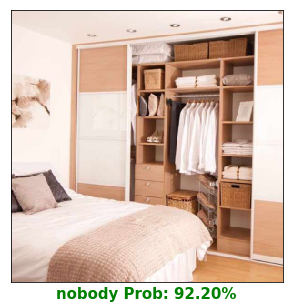

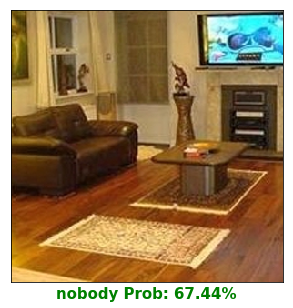

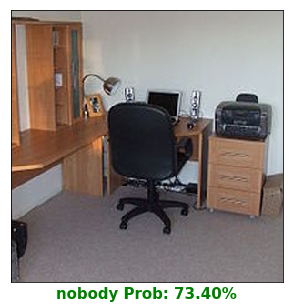

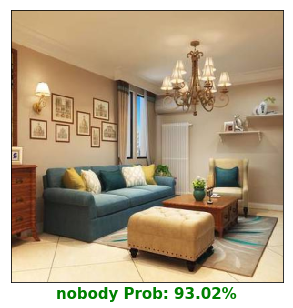

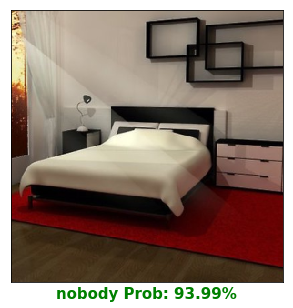

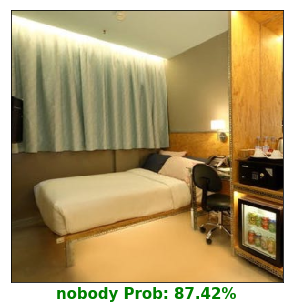

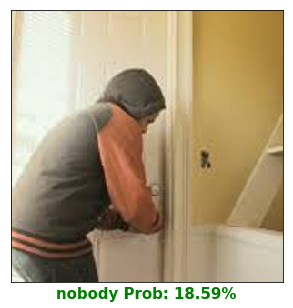

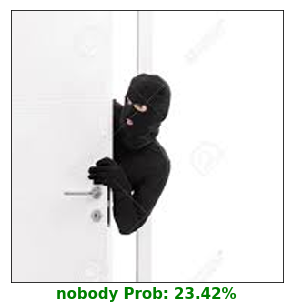

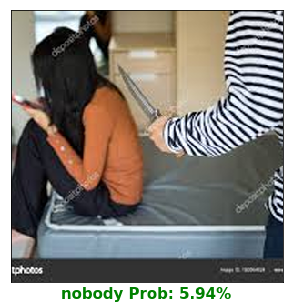

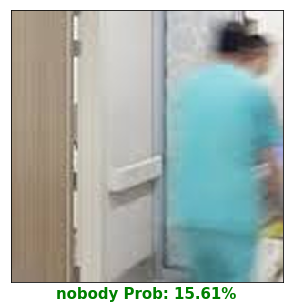

In [2]:
# plot results
fig = plt.figure()
fig.suptitle('Predictions on Test Images', size=15, weight='bold')
fig.subplots_adjust(hspace=1, wspace=5)
for i in range(10):
#     ax = fig.add_subplot(4, 3, i+1)
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.set_xticks([])
    ax.set_yticks([])
#     ax.imshow(images_rgb[i], aspect='auto')
    ax.imshow(images_rgb[i])
    result = 'nobody Prob: {:.2f}%'.format(predictions[i][0]*100)
    ax.set_xlabel(result, color='g', size=15, weight='bold', horizontalalignment='center')

plt.show()